<a href="https://colab.research.google.com/github/Jiali03713/Sentiment-NLP-/blob/main/Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/keras-team/keras-tuner
!cd keras-tuner
!pip install keras-tuner --upgrade

from kerastuner import tuners

Cloning into 'keras-tuner'...
remote: Enumerating objects: 9212, done.
remote: Counting objects: 100% (805/805), done.
remote: Compressing objects: 100% (257/257), done.
remote: Total 9212 (delta 639), reused 639 (delta 548), pack-reused 8407
Receiving objects: 100% (9212/9212), 2.16 MiB | 6.54 MiB/s, done.
Resolving deltas: 100% (6572/6572), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 688.4 kB/s eta 0:00:00


<ipython-input-1-3d5757166e11>:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import tuners


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/'Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# from textblob import TextBlob
# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# from flair.models import TextClassifier
# from flair.data import Sentence
import tensorflow as tf
import tensorflow_hub as hub

import keras
from keras import Sequential
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.optimizers import schedules
from keras.optimizers import SGD
from keras.optimizers.schedules import ExponentialDecay


import matplotlib.pyplot as plt
from kerastuner import HyperParameters
from kerastuner import tuners
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


import numpy as np
import os
import pandas as pd
import keras_tuner

import csv

In [ ]:
DATASET_ENCODING = "latin-1"

# #textblob
# testimonial = TextBlob("The food was great...")
# print(testimonial.sentiment)
#
# #Vader
# analyer = SentimentIntensityAnalyzer()
# sentence = "The food was disgusting"
# vs = analyer.polarity_scores(sentence)
# print(vs)

# classifier = TextClassifier.load('en-sentiment')
# sentence = Sentence('The party is savage!')
# classifier.predict(sentence)
# print('Sentence above is:', sentence.labels)

file_path = '/content/training.1600000.processed.noemoticon.csv'

const = pd.read_csv(file_path, encoding=DATASET_ENCODING, engine='python')
const = const.iloc[:, [0, -1]]
const.columns = ['sentiment', 'tweet']
const = pd.concat([const.query("sentiment==0").sample(20000), const.query("sentiment==4").sample(20000)])
const.sentiment = const.sentiment.map({0: 0, 4: 1})
const = shuffle(const).reset_index(drop=True)

const, const_test = train_test_split(const, test_size=0.2)

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed(['hi samuels, this is our project']).numpy().shape



(1, 512)

In [ ]:
df = const.copy()
df_test = const_test.copy()

In [ ]:
def vectorize(df):
	embeded_tweets = embed(df['tweet'].values.tolist()).numpy()
	targets = df.sentiment.values
	return embeded_tweets, targets


embeded_tweets, targets = vectorize(df)

In [ ]:
early_stopping = EarlyStopping(
	min_delta=0.005,
	patience=30,
	restore_best_weights=True,
)


In [ ]:
hp = keras_tuner.HyperParameters()
# Learning Rate
initial_learning_rate = 0.01
lr_schedule = schedules.ExponentialDecay(
	initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)
optimizer = SGD(learning_rate=lr_schedule)
learning_rate = hp.Float("lr", min_value=1e-3, max_value=1e-2, sampling="log")


In [ ]:
# Model Setting
model = keras.Sequential([
	keras.layers.BatchNormalization(input_shape=(512,)),
	keras.layers.Dense(units=hp.Int(name="units1", min_value=32, max_value=256, step=32),
					   activation='LeakyReLU'),
	keras.layers.Dense(units=hp.Int(name="units2", min_value=32, max_value=256, step=32),
					   activation='LeakyReLU'),
	keras.layers.Dense(1)
]
)

In [ ]:
model.compile(loss='binary_crossentropy',
			  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
			  metrics=['accuracy', tf.keras.metrics.Recall()])
num_epochs = 150
batch_size = 64  ## 2^x
history = model.fit(embeded_tweets,
					targets,
					epochs=num_epochs,
					validation_split=0.3,
					shuffle=True,
					batch_size=batch_size,
					callbacks=[early_stopping])

Epoch 1/150
350/350 [==============================] - 3s 4ms/step - loss: 2.8035 - accuracy: 0.6811 - recall_4: 0.6692 - val_loss: 0.6907 - val_accuracy: 0.6686 - val_recall_4: 0.4375
Epoch 2/150
350/350 [==============================] - 2s 6ms/step - loss: 1.3298 - accuracy: 0.6954 - recall_4: 0.6821 - val_loss: 0.7532 - val_accuracy: 0.6975 - val_recall_4: 0.6190
Epoch 3/150
350/350 [==============================] - 2s 6ms/step - loss: 0.8334 - accuracy: 0.6937 - recall_4: 0.6366 - val_loss: 0.7367 - val_accuracy: 0.7070 - val_recall_4: 0.6596
Epoch 4/150
350/350 [==============================] - 1s 4ms/step - loss: 0.6664 - accuracy: 0.7067 - recall_4: 0.6844 - val_loss: 0.6342 - val_accuracy: 0.7264 - val_recall_4: 0.7057
Epoch 5/150
350/350 [==============================] - 1s 4ms/step - loss: 0.5995 - accuracy: 0.7295 - recall_4: 0.6786 - val_loss: 0.5960 - val_accuracy: 0.7228 - val_recall_4: 0.6615
Epoch 6/150
350/350 [==============================] - 1s 4ms/step - loss: 

250/250 [==============================] - 1s 4ms/step
Accuracy: 55.33749999999999


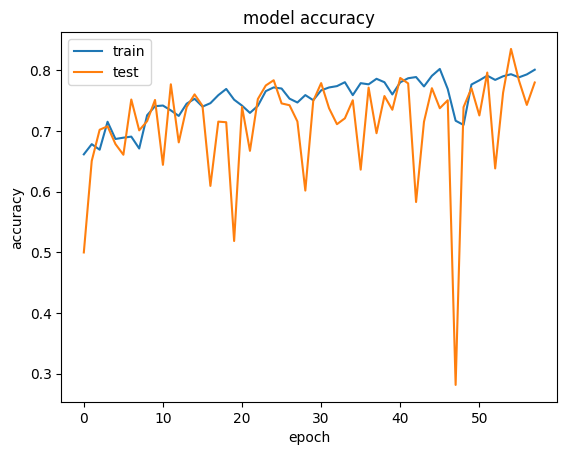

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_recall_2'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("plot")

# Accuracy
from sklearn.metrics import accuracy_score

embed_test, targets = vectorize(df_test)
predictions = model.predict(embed_test).astype(int)
print("Accuracy: " + str(accuracy_score(predictions, targets) * 100))